In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.callbacks import TensorBoard


import warnings
warnings.filterwarnings("ignore")

In [2]:
os.getcwd()

'C:\\Users\\pavan'

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [5]:
def train_df(tr_path):
    classes = []
    class_paths = []
    files = os.listdir(tr_path)
    for file in files:
        label_dir = os.path.join(tr_path, file)
        label = os.listdir(label_dir)
        for image in label:
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            classes.append(file)
    image_classes = pd.Series(classes, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    tr_df = pd.concat([image_paths, image_classes], axis=1)
    return tr_df

In [7]:
# Example path (update it to your actual path)
dataset_directory = r'C:\vit 7th semester\soft computing\dataset'  # Change to your actual path


Loaded 1184 images.
Loaded labels: ['anger' 'disgust' 'fear' 'happy' 'pain' 'sad']


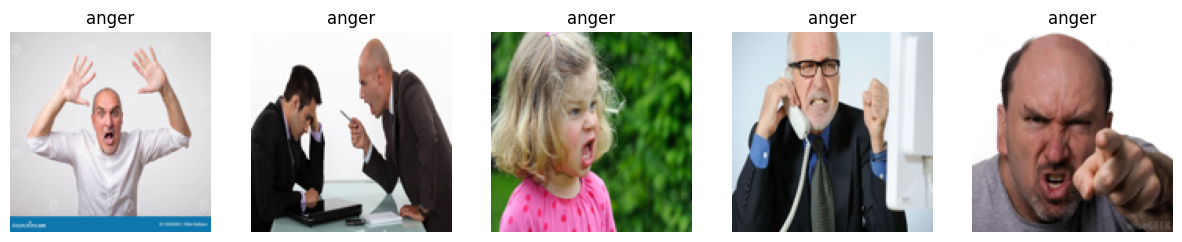

In [9]:
# Lists to hold image data and labels
images = []
labels = []

# Define the classes
classes = ['anger', 'disgust', 'fear', 'happy', 'pain', 'sad']

# Loop through each class folder
for label in classes:
    class_folder = os.path.join(dataset_directory, label)
    
    # Check if the folder exists
    if os.path.isdir(class_folder):
        for image_file in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_file)
            
            # Load the image
            try:
                image = Image.open(image_path)
                image = image.resize((128, 128))  # Resize the image to a consistent shape
                images.append(np.array(image))  # Convert to array and add to the list
                labels.append(label)  # Add the corresponding label
            except Exception as e:
                print(f"Could not load image {image_path}: {e}")

# Filter images and labels to ensure they are consistent
valid_images = []
valid_labels = []

for img, lbl in zip(images, labels):
    if img.shape == (128, 128, 3):  # Check for consistency
        valid_images.append(img)
        valid_labels.append(lbl)

# Convert the lists to numpy arrays for easier handling
images = np.array(valid_images)
labels = np.array(valid_labels)

# Check loaded data
print(f"Loaded {len(images)} images.")
print(f"Loaded labels: {np.unique(labels)}")

# Function to display images and labels
def display_images(images, labels, num_images=5):
    plt.figure(figsize=(15, 8))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

# Display the first 5 images
display_images(images, labels, num_images=5)


In [10]:
tr_df = train_df(r'C:\vit 7th semester\soft computing\dataset')

In [8]:
tr_df

,Class Path,Class
0,C:\vit 7th semester\soft computing\dataset\ang...,anger
1,C:\vit 7th semester\soft computing\dataset\ang...,anger
2,C:\vit 7th semester\soft computing\dataset\ang...,anger
3,C:\vit 7th semester\soft computing\dataset\ang...,anger
4,C:\vit 7th semester\soft computing\dataset\ang...,anger
...,...,...
1189,C:\vit 7th semester\soft computing\dataset\sad...,sad
1190,C:\vit 7th semester\soft computing\dataset\sad...,sad
1191,C:\vit 7th semester\soft computing\dataset\sad...,sad
1192,C:\vit 7th semester\soft computing\dataset\sad...,sad


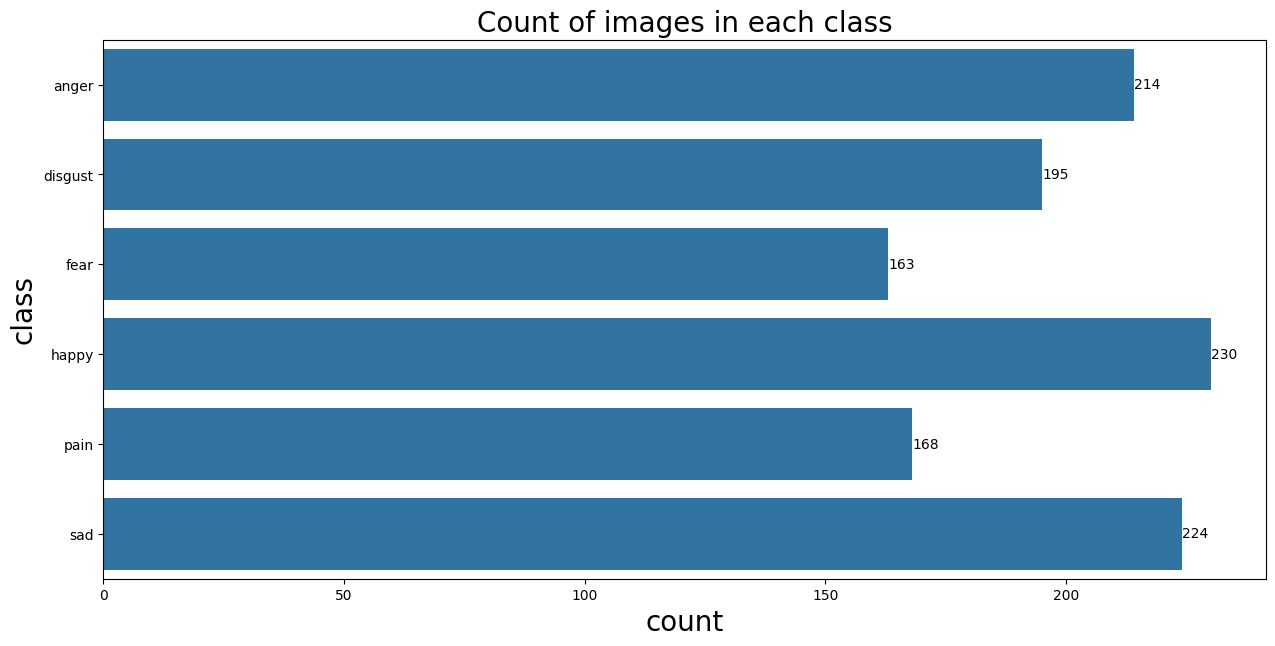

In [9]:
# Count of images in each class
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df , y=tr_df['Class'])

plt.xlabel('count',fontsize=20)
plt.ylabel('class',fontsize=20)
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

In [10]:
# 3. Split data into train, test and valid
tr_df, ts_df = train_test_split(tr_df,  train_size= 0.8, shuffle= True, random_state= 20)
valid_df, ts_df = train_test_split(ts_df,  train_size= 0.5, shuffle= True, random_state= 20)

In [11]:
tr_df

,Class Path,Class
1155,C:\vit 7th semester\soft computing\dataset\sad...,sad
641,C:\vit 7th semester\soft computing\dataset\hap...,happy
439,C:\vit 7th semester\soft computing\dataset\fea...,fear
71,C:\vit 7th semester\soft computing\dataset\ang...,anger
752,C:\vit 7th semester\soft computing\dataset\hap...,happy
...,...,...
226,C:\vit 7th semester\soft computing\dataset\dis...,disgust
1,C:\vit 7th semester\soft computing\dataset\ang...,anger
269,C:\vit 7th semester\soft computing\dataset\dis...,disgust
659,C:\vit 7th semester\soft computing\dataset\hap...,happy


In [29]:
ts_df

,Class Path,Class
920,C:\vit 7th semester\soft computing\dataset\pai...,pain
930,C:\vit 7th semester\soft computing\dataset\pai...,pain
1029,C:\vit 7th semester\soft computing\dataset\sad...,sad
1103,C:\vit 7th semester\soft computing\dataset\sad...,sad
175,C:\vit 7th semester\soft computing\dataset\ang...,anger
...,...,...
328,C:\vit 7th semester\soft computing\dataset\dis...,disgust
379,C:\vit 7th semester\soft computing\dataset\dis...,disgust
506,C:\vit 7th semester\soft computing\dataset\fea...,fear
1172,C:\vit 7th semester\soft computing\dataset\sad...,sad


In [11]:
# 4. Preprocessing
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (224, 224, 3)

gen = ImageDataGenerator(rotation_range=30,
                         shear_range=.1,
                         zoom_range=.1,
                         horizontal_flip=True)


ts_gen = ImageDataGenerator()

tr_gen = gen.flow_from_dataframe(tr_df, x_col= 'Class Path',
                                 y_col= 'Class', target_size= img_size,
                                 color_mode= 'rgb', shuffle= True,
                                 batch_size= batch_size)

valid_gen = gen.flow_from_dataframe(valid_df, x_col= 'Class Path',
                                    y_col= 'Class', target_size= img_size,
                                    color_mode= 'rgb', shuffle= True,
                                    batch_size= batch_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col= 'Class Path',
                                 y_col= 'Class', target_size= img_size,
                                 color_mode= 'rgb', shuffle= False,
                                 batch_size= batch_size)

Found 915 validated image filenames belonging to 6 classes.
Found 115 validated image filenames belonging to 6 classes.
Found 116 validated image filenames belonging to 6 classes.


In [13]:
images, labels = next(ts_gen) 
print(f"Number of images in the batch: {images.shape[0]}")  # Print the number of images


Number of images in the batch: 16


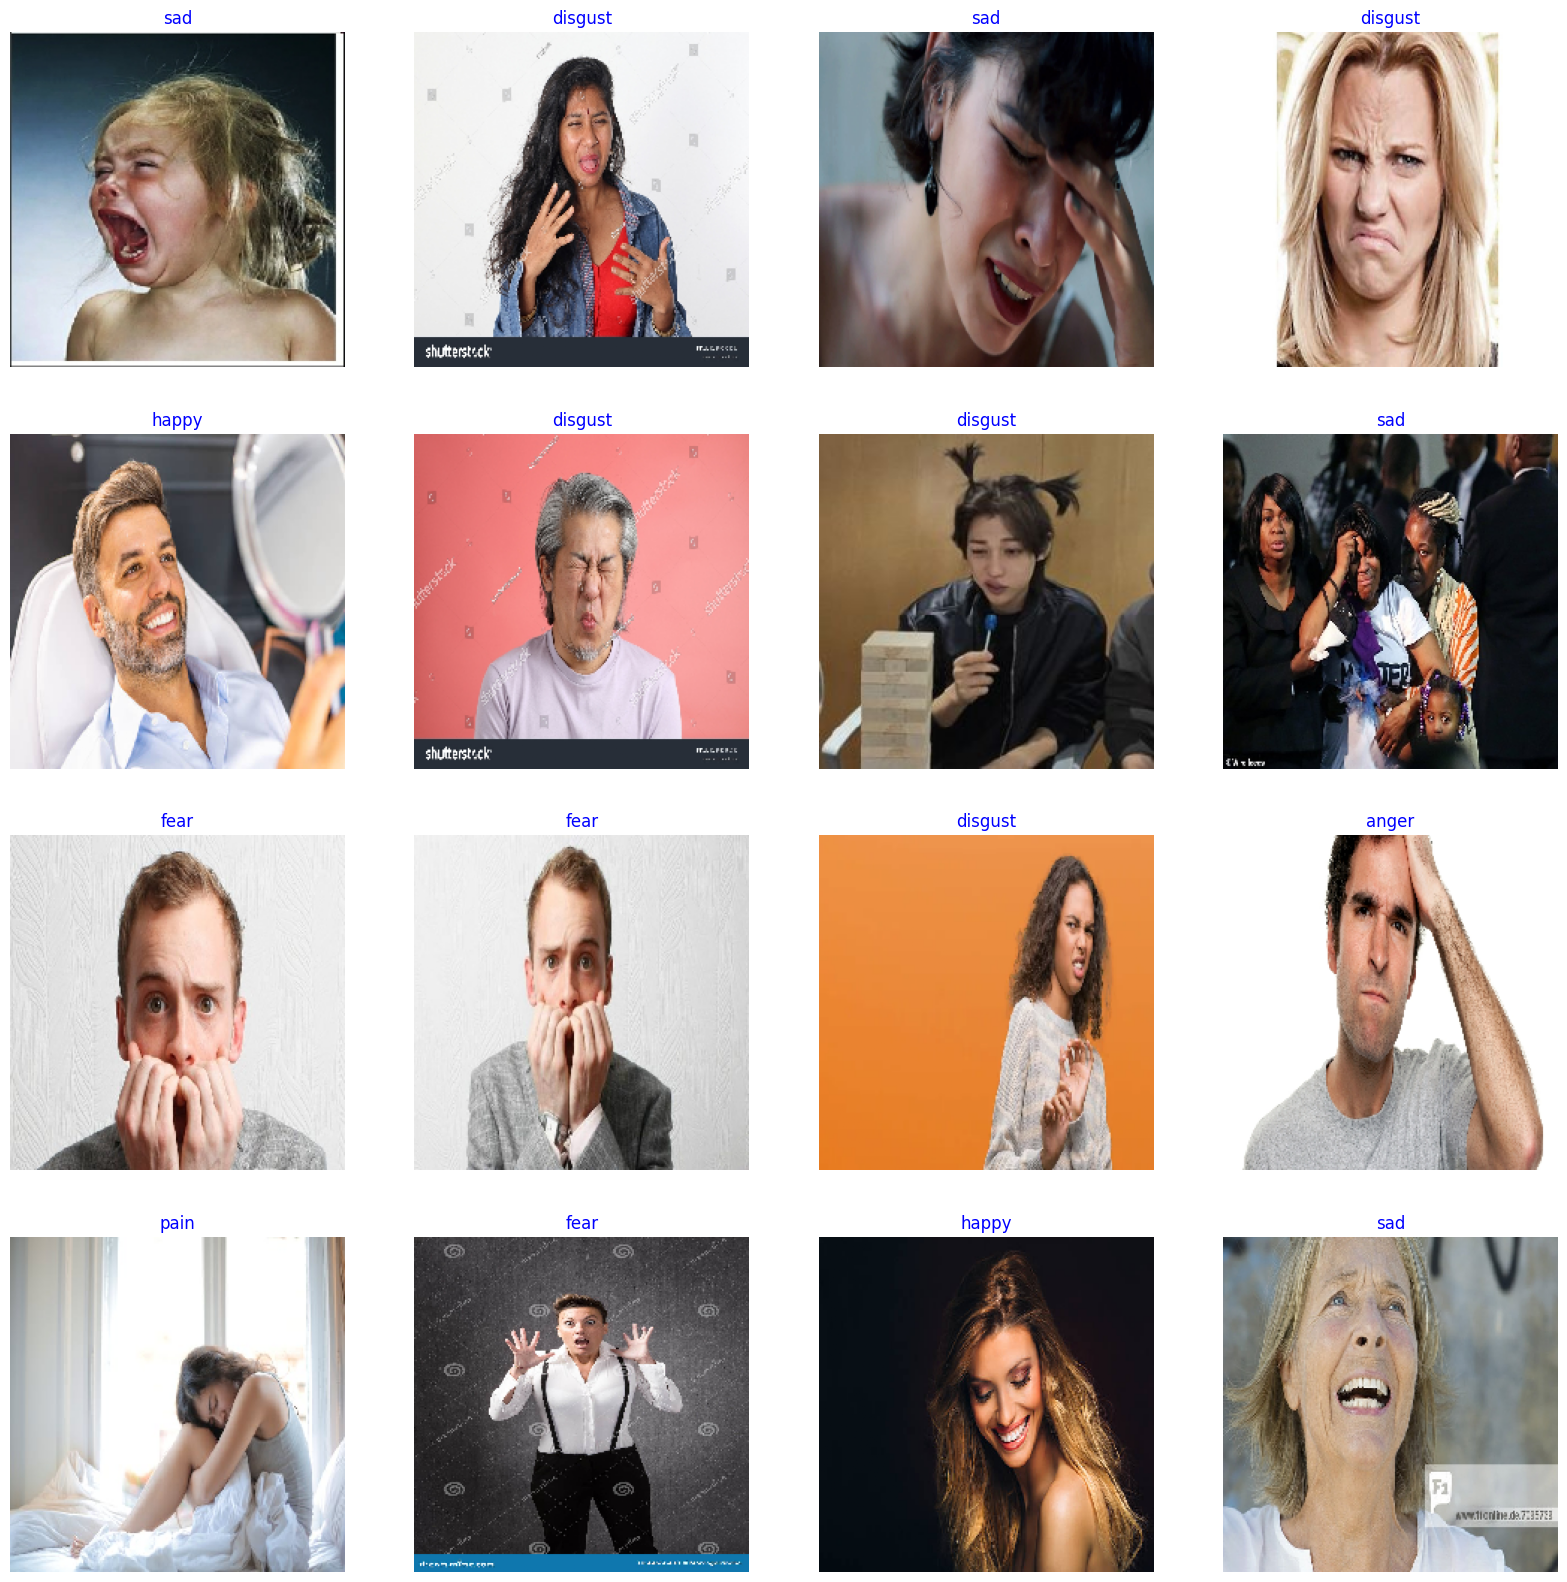

In [14]:
#4.1 Show samples from traning data
g_dict = tr_gen.class_indices      
g_dict = tr_gen.class_indices      
classes = list(g_dict.keys())       
images, labels = next(ts_gen) 

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [6]:
#5. Build Deep Learning Mode
# Define the image shape
img_shape = (224, 224, 3)

base_model = EfficientNetB3(include_top=False, weights="imagenet",
                      input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    Dense(512,activation= 'relu'),
    Dropout(rate= 0.40, seed= 20),
    Dense(6, activation= 'softmax')
])

for layer in base_model.layers:
    layer.trainable = False
    

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])


model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         786,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,573,557 (44.15 MB)

 Trainable params: 790,022 (3.01 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [7]:
for layer in base_model.layers[1000:]:
    layer.trainable = True
    
model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         786,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,573,557 (44.15 MB)

 Trainable params: 790,022 (3.01 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [8]:
for layer in base_model.layers:
    layer.trainable = True
    
model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         786,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,573,557 (44.15 MB)

 Trainable params: 11,486,254 (43.82 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [9]:
# 6. Train
logdir='logs'


In [10]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [51]:
#     layer.trainable = False
hist = model.fit(tr_gen, epochs=10, validation_data=valid_gen, callbacks=[tensorboard_callback])

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 443s 7s/step - accuracy: 0.2501 - loss: 6.9153 - precision_7: 0.2580 - recall_7: 0.2239 - val_accuracy: 0.3370 - val_loss: 1.7912 - val_precision_7: 0.4583 - val_recall_7: 0.2391
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 320s 7s/step - accuracy: 0.5104 - loss: 1.2770 - precision_7: 0.6398 - recall_7: 0.3561 - val_accuracy: 0.4674 - val_loss: 1.5572 - val_precision_7: 0.5769 - val_recall_7: 0.3261
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 305s 7s/step - accuracy: 0.6291 - loss: 1.0193 - precision_7: 0.7757 - recall_7: 0.4861 - val_accuracy: 0.6087 - val_loss: 1.1948 - val_precision_7: 0.7231 - val_recall_7: 0.5109
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 303s 7s/step - accuracy: 0.7159 - loss: 0.7385 - precision_7: 0.8104 - recall_7: 0.6221 - val_accuracy: 0.6413 - val_loss: 1.1032 - val_precision_7: 0.7042 - val_recall_7: 0.5435
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 303s 7s/step - accuracy: 0.7641 - loss: 0.7068 - precision_7: 0.8286 - recall_7: 0.6705 - val_

In [52]:
#layer.trainable[200: ] = True
hist = model.fit(tr_gen,
                 epochs=10,
                 validation_data=valid_gen,
                 shuffle= False,
                 callbacks=[tensorboard_callback])

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 314s 7s/step - accuracy: 0.9423 - loss: 0.1973 - precision_7: 0.9470 - recall_7: 0.9307 - val_accuracy: 0.6630 - val_loss: 1.2960 - val_precision_7: 0.7011 - val_recall_7: 0.6630
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 324s 7s/step - accuracy: 0.9360 - loss: 0.1845 - precision_7: 0.9497 - recall_7: 0.9266 - val_accuracy: 0.6739 - val_loss: 1.1957 - val_precision_7: 0.7108 - val_recall_7: 0.6413
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 336s 7s/step - accuracy: 0.9491 - loss: 0.1242 - precision_7: 0.9586 - recall_7: 0.9437 - val_accuracy: 0.6957 - val_loss: 1.1179 - val_precision_7: 0.7273 - val_recall_7: 0.6957
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 328s 7s/step - accuracy: 0.9647 - loss: 0.1111 - precision_7: 0.9711 - recall_7: 0.9569 - val_accuracy: 0.6522 - val_loss: 1.3728 - val_precision_7: 0.6667 - val_recall_7: 0.6522
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 350s 8s/step - accuracy: 0.9496 - loss: 0.1424 - precision_7: 0.9535 - recall_7: 0.9472 - val_

In [16]:
# Create a log directory for TensorBoard
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Create TensorBoard callback
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# layer.trainable = True
hist = model.fit(tr_gen,
                 epochs=25,
                 validation_data=valid_gen,
                 shuffle= False,
                 callbacks=[tensorboard_callback])

Epoch 1/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.2312 - loss: 5.0475 - precision: 0.2410 - recall: 0.2177 - val_accuracy: 0.3478 - val_loss: 2.0948 - val_precision: 0.4133 - val_recall: 0.2696
Epoch 2/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.3929 - loss: 1.9028 - precision: 0.4421 - recall: 0.2906 - val_accuracy: 0.4348 - val_loss: 1.5795 - val_precision: 0.6818 - val_recall: 0.2609
Epoch 3/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.4558 - loss: 1.4308 - precision: 0.6062 - recall: 0.2576 - val_accuracy: 0.3913 - val_loss: 1.4536 - val_precision: 0.5625 - val_recall: 0.2348
Epoch 4/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.5035 - loss: 1.3441 - precision: 0.6643 - recall: 0.3343 - val_accuracy: 0.4348 - val_loss: 1.5473 - val_precision: 0.6327 - val_recall: 0.2696
Epoch 5/25
58/58 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.5206 - loss: 1.2754 - precision: 0.6586 - recall: 0.3266 - val_accuracy: 0.4174 - val_loss: 1.5101 - va

In [11]:
# After training, save the model
model_path = 'C:/Users/pavan/OneDrive/Desktop/emotion-classifier/backend/model/your_model.h5'  # Change this path if needed
model.save(model_path)
print(f'Model saved at {model_path}')

Model saved at C:/Users/pavan/OneDrive/Desktop/emotion-classifier/backend/model/your_model.h5


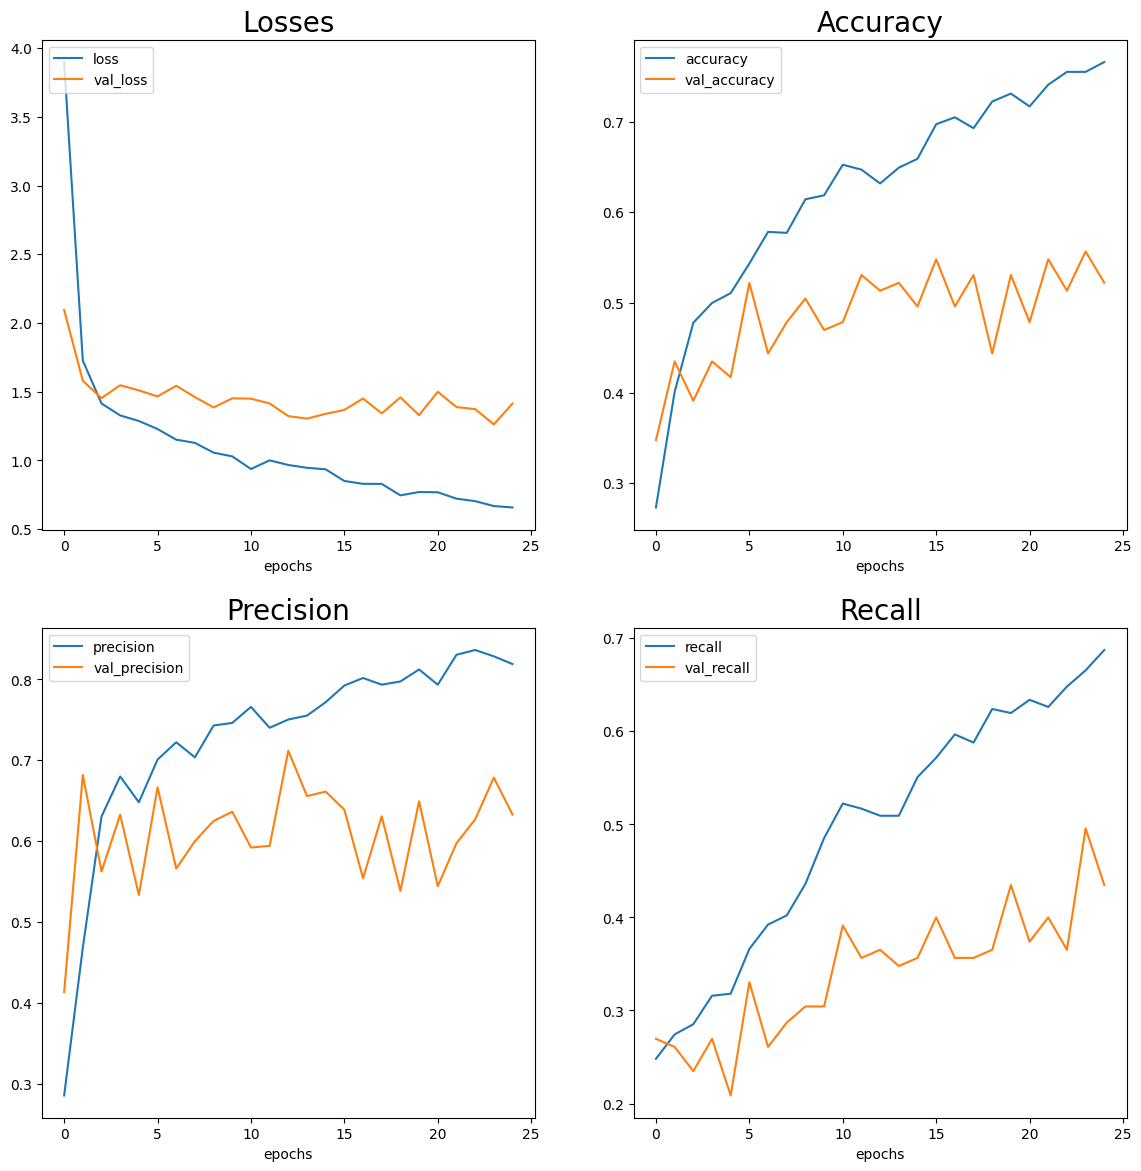

In [19]:
# 7.Plot Performance
plt.figure(figsize= (14, 14))

plt.subplot(2,2,1)
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.title('Losses', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

plt.subplot(2,2,2)
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

plt.subplot(2,2,3)
plt.plot(hist.history['precision'], label='precision')
plt.plot(hist.history['val_precision'], label='val_precision')
plt.title('Precision', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

plt.subplot(2,2,4)
plt.plot(hist.history['recall'], label='recall')
plt.plot(hist.history['val_recall'], label='val_recall')
plt.title('Recall', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

plt.show()

In [20]:
# 8. Evaluate
train_score = model.evaluate(tr_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(ts_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

58/58 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8993 - loss: 0.3818 - precision: 0.9418 - recall: 0.8283
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5544 - loss: 1.2977 - precision: 0.6002 - recall: 0.3913
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6323 - loss: 1.1777 - precision: 0.7255 - recall: 0.5310
Train Loss:  0.39452236890792847
Train Accuracy:  0.8918032646179199
--------------------
Validation Loss:  1.3852065801620483
Validation Accuracy:  0.5130434632301331
--------------------
Test Loss:  1.1531767845153809
Test Accuracy:  0.6465517282485962


In [22]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step


In [23]:

print(classification_report(ts_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

       anger       0.48      0.69      0.56        16
     disgust       0.70      0.41      0.52        17
        fear       0.93      0.70      0.80        20
       happy       0.50      0.79      0.61        19
        pain       0.75      0.64      0.69        14
         sad       0.73      0.63      0.68        30

    accuracy                           0.65       116
   macro avg       0.68      0.64      0.64       116
weighted avg       0.69      0.65      0.65       116



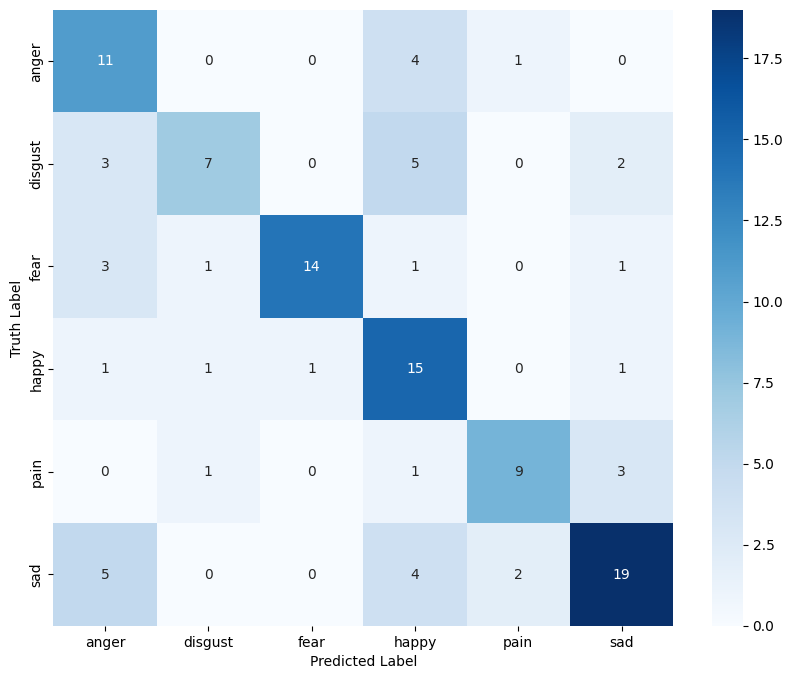

In [24]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(g_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [1]:
# 1. Import Libraries
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report
import numpy as np

# 2. Evaluate the model on the test set using model.evaluate()
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(ts_gen, verbose=1)

# Print out the basic metrics
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_accuracy)
print("Test Precision: ", test_precision)
print("Test Recall: ", test_recall)

NameError: name 'model' is not defined